# Task 14
## Subtask 2: Numba is used, Subtask 3: Acceleration using numba achieved
## my implementation With JIT

Populating the interactive namespace from numpy and matplotlib


/home/stas/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


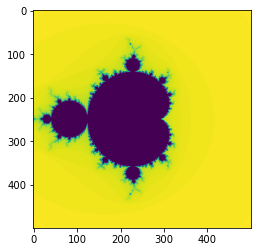

In [8]:
%pylab inline
from numba import njit
import seaborn as sns

@njit(fastmath=True)
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
    fig = plt.figure(figsize=(14, 11))
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )   
    # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    plt.close(fig)

    return image
    
image = juliaSetRainbow(size = 1.5, pixels = 500, max_iterations = 100, infinity_border = 2)
plt.imshow(image)

# my implementation Without JIT

In [3]:
%pylab inline
from numba import njit
import seaborn as sns

#@njit(fastmath=True)
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
#     fig = plt.figure(figsize=(14, 11))
#     sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
#                 # cbar_kws= {'orientation': 'vertical'}
#                )   
#     # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
#     plt.ylabel('Imaginary(z_inf)', fontsize=20)
#     plt.xlabel('Real(z_inf)', fontsize=20)
#     plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
#     plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
#     plt.close(fig)

    return image
    
%timeit image = juliaSetRainbow(size = 1.5, pixels = 500, max_iterations = 100, infinity_border = 2)
# plt.imshow(image)

Populating the interactive namespace from numpy and matplotlib
994 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### shared implementation With JIT

In [5]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

%timeit image = create_image()

# plt.imshow(image)

24.6 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# shared implementation Without JIT

In [4]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import njit

#@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

%timeit image = create_image()

# plt.imshow(image)

1.74 s ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Shared code profiling

## Subtask 1: Mandelbrot code is profiled

In [49]:
#%%writefile mandelbrot.py
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

image = create_image()
#plt.imshow(image)

In [39]:
%load_ext snakeviz
%snakeviz create_image()

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/tmp/tmp0s593rwd'. 
Embedding SnakeViz in this document...


## Subtask 4: Measuring computation time - number of total iterations vs computational time (JITed, regular)
### Without JIT

In [7]:
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

#@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

451.2831389999974 mSec
616.3075650001701 mSec
762.4729920000846 mSec
916.6810870001427 mSec
1049.316120999947 mSec
1208.1071299999167 mSec
1353.006526999934 mSec
1480.3156390000822 mSec
1624.9566630001482 mSec
1762.0144170000458 mSec
1896.3926220001213 mSec
2047.620889999962 mSec
2171.190420999892 mSec
2307.3229450001236 mSec
2699.9634960000094 mSec
2553.5822090000693 mSec
2728.9742999998907 mSec
2823.165248999885 mSec
2964.144400000123 mSec
3161.04572800009 mSec
3408.0239329998676 mSec
3441.3747090000015 mSec
3605.3399370000534 mSec
3661.2365840001075 mSec
4208.473200999833 mSec
3963.27475399994 mSec
4264.771174000089 mSec
4426.981552999905 mSec
4479.634037000096 mSec


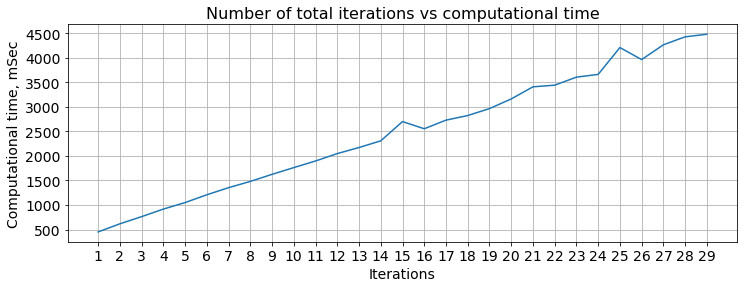

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

### With JIT

In [47]:
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

@njit
def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = 0
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

237.6898490001622 mSec
6.753779000064242 mSec
9.196633000101428 mSec
11.29582199973811 mSec
14.28192799903627 mSec
16.222972999457852 mSec
18.453192000379204 mSec
20.375586000227486 mSec
22.290556000370998 mSec
24.97778000179096 mSec
26.874177001445787 mSec
28.96490300008736 mSec
31.423551999978372 mSec
33.31884200088098 mSec
34.93145100037509 mSec
37.05048700066982 mSec
38.94359600053576 mSec
43.196409998927265 mSec
43.1902109994553 mSec
45.604839999214164 mSec
47.736468999573844 mSec
53.44777100071951 mSec
53.93940800058772 mSec
55.17826700088335 mSec
56.95420499978354 mSec
56.37214300077176 mSec
59.2447799990623 mSec
60.4677269984677 mSec
62.35369699970761 mSec


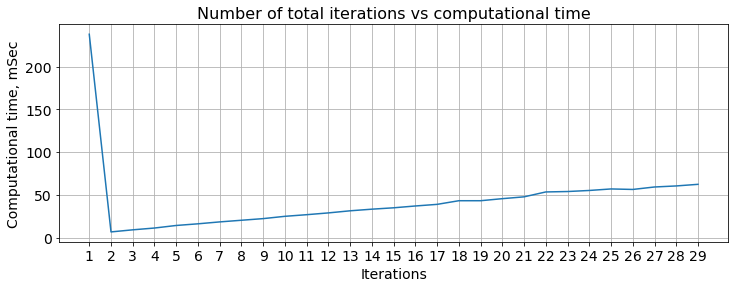

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()